In [1]:
import pandas as pd
from pandas import option_context
import numpy as np
from tqdm import tqdm
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance
import skops.io as sio

from sklearn.metrics import roc_auc_score, confusion_matrix, make_scorer, precision_recall_fscore_support
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc

import activity_features_all as atf
# import important_features as atf
import GenerateActivities as gat

from scipy.stats import mannwhitneyu
import cliffsDelta as cd

## Testing the best model

In [2]:
RAND_SEED = 7
SPLIT = 0.4

In [3]:
'''
Important features of the data
'''
important_features = ['feat_num_activities',
 'feat_num_activity_type',
 'feat_owner',
 'feat_ratio_owner_repo',
 'consecutive_activity_time_mean',
 'consecutive_activity_time_50%',
 'consecutive_activity_time_std',
 'consecutive_activity_time_gini',
 'activity_per_repo_mean',
 'activity_per_repo_50%',
 'activity_per_repo_gini',
 'activity_per_repo_IQR',
 'activity_type_per_repo_mean',
 'activity_type_per_repo_50%',
 'activity_type_per_repo_std',
 'activity_type_per_repo_gini',
 'continuous_activity_repo_mean',
 'continuous_activity_repo_std',
 'continuous_activity_repo_IQR',
 'time_spent_in_repo_mean',
 'time_spent_in_repo_50%',
 'time_spent_in_repo_std',
 'time_spent_in_repo_IQR',
 'time_to_switch_repo_mean',
 'time_to_switch_repo_50%',
 'time_to_switch_repo_std',
 'time_to_switch_repo_gini',
 'time_to_switch_repo_IQR',
 'time_to_switch_act_type_mean',
 'time_to_switch_act_type_50%',
 'time_to_switch_act_type_std',
 'time_to_switch_act_type_gini',
 'time_to_switch_act_type_IQR',
 'activity_per_act_type_mean',
 'activity_per_act_type_50%',
 'activity_per_act_type_std',
 'activity_per_act_type_gini',
 'activity_per_act_type_IQR']

## Reading features and splitting it into training and test set - same seed used for grid search

In [4]:
df_features_read = pd.read_csv('../data/features0305.csv',index_col=0).sort_index()

In [5]:
ground_truth = pd.read_csv('../data/total_contributors_with_dataset.csv').set_index('contributor')

In [6]:
df_features = (
               df_features_read
               .merge(ground_truth.drop('dataset',axis=1), left_index=True, right_index=True)
               .assign(bot = lambda d: np.where(d.acc_type_y == "human", 0, 1))
               .drop(['acc_type_x', 'acc_type_y'],axis=1)
               .assign(contributor = lambda d: d.index.str.replace('[bot]','',regex=False))
               .set_index('contributor')
               .sort_index()
              )
with option_context('display.max_column',None):
    display(df_features.query('bot == 1'))

,feat_num_activities,feat_num_activity_type,feat_repos,feat_owner,feat_ratio_owner_repo,consecutive_activity_time_mean,consecutive_activity_time_50%,consecutive_activity_time_std,consecutive_activity_time_gini,consecutive_activity_time_IQR,activity_per_repo_mean,activity_per_repo_50%,activity_per_repo_std,activity_per_repo_gini,activity_per_repo_IQR,activity_type_per_repo_mean,activity_type_per_repo_50%,activity_type_per_repo_std,activity_type_per_repo_gini,activity_type_per_repo_IQR,continuous_activity_repo_mean,continuous_activity_repo_50%,continuous_activity_repo_std,continuous_activity_repo_gini,continuous_activity_repo_IQR,time_spent_in_repo_mean,time_spent_in_repo_50%,time_spent_in_repo_std,time_spent_in_repo_gini,time_spent_in_repo_IQR,time_to_switch_repo_mean,time_to_switch_repo_50%,time_to_switch_repo_std,time_to_switch_repo_gini,time_to_switch_repo_IQR,time_to_switch_act_type_mean,time_to_switch_act_type_50%,time_to_switch_act_type_std,time_to_switch_act_type_gini,time_to_switch_act_type_IQR,activity_per_act_type_mean,activity_per_act_type_50%,activity_per_act_type_std,activity_per_act_type_gini,activity_per_act_type_IQR,bot
contributor,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1gtm,299,3,23,4,0.174,0.081,0.000,0.679,0.970,0.003,13.000,8.0,13.655,0.490,10.00,1.957,2.0,0.367,0.062,0.0,6.795,3.0,9.849,0.567,4.25,0.206,0.001,1.275,0.956,0.010,0.352,0.017,1.212,0.897,0.045,0.017,0.000,0.191,0.950,0.001,99.667,146.0,85.500,0.337,75.50,1
24emebot,279,1,1,1,1.000,7.589,0.584,15.767,0.786,6.146,279.000,279.0,0.000,0.000,0.00,1.000,1.0,0.000,0.000,0.0,279.000,279.0,0.000,0.000,0.00,2109.750,2109.750,0.000,0.000,0.000,NaN,NaN,0.000,0.000,NaN,NaN,NaN,0.000,0.000,NaN,279.000,279.0,0.000,0.000,0.00,1
47erbot,201,7,12,3,0.250,1.930,0.003,9.800,0.960,0.012,16.750,12.0,15.058,0.392,8.50,4.667,5.0,1.231,0.095,0.0,2.871,3.0,1.710,0.275,1.00,1.237,0.000,7.341,0.965,0.004,4.339,0.012,14.939,0.927,0.020,2.013,0.001,10.149,0.958,0.010,28.714,31.0,12.945,0.215,6.50,1
5imon-bot,56,1,3,1,0.333,36.690,0.311,76.716,0.813,26.075,18.667,8.0,19.348,0.405,17.00,1.000,1.0,0.000,0.000,0.0,4.308,1.0,8.430,0.629,2.00,33.451,0.000,62.265,0.519,45.408,131.922,114.406,115.178,0.456,134.859,NaN,NaN,0.000,0.000,NaN,56.000,56.0,0.000,0.000,0.00,1
9cibot,27,2,1,1,1.000,38.672,0.097,112.949,0.864,0.215,27.000,27.0,0.000,0.000,0.00,2.000,2.0,0.000,0.000,0.0,27.000,27.0,0.000,0.000,0.00,1005.467,1005.467,0.000,0.000,0.000,NaN,NaN,0.000,0.000,NaN,10.420,0.048,41.244,0.884,0.102,13.500,13.5,7.778,0.204,5.50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zksync-admin-bot2,51,4,5,1,0.200,41.947,0.560,97.237,0.820,39.724,10.200,3.0,11.584,0.518,14.00,2.400,2.0,0.548,0.100,1.0,3.923,3.0,3.201,0.395,3.00,34.610,0.196,94.986,0.827,12.673,137.286,86.892,159.089,0.535,95.312,43.350,0.095,108.175,0.848,13.403,12.750,13.5,5.909,0.221,5.75,1
zorro-bot,85,3,1,1,1.000,25.382,11.938,39.925,0.660,26.623,85.000,85.0,0.000,0.000,0.00,3.000,3.0,0.000,0.000,0.0,85.000,85.0,0.000,0.000,0.00,2132.089,2132.089,0.000,0.000,0.000,NaN,NaN,0.000,0.000,NaN,30.598,17.293,41.522,0.584,30.556,28.333,8.0,38.734,0.541,34.50,1
zube,43,3,7,5,0.714,12.025,1.843,21.076,0.746,12.083,6.143,1.0,7.034,0.545,9.50,1.429,1.0,0.535,0.171,1.0,2.389,1.0,2.429,0.443,1.00,9.460,0.000,26.561,0.717,0.015,19.693,6.962,28.264,0.655,14.387,12.800,6.231,21.420,0.698,6.705,14.333,4.0,19.655,0.543,17.50,1


In [7]:
df_features.columns[df_features.isna().any()]

Index(['time_to_switch_repo_mean', 'time_to_switch_repo_50%',
       'time_to_switch_repo_IQR', 'time_to_switch_act_type_mean',
       'time_to_switch_act_type_50%', 'time_to_switch_act_type_IQR'],
      dtype='object')

In [8]:
df_features.bot.value_counts()

0    1115
1    1035
Name: bot, dtype: int64

## Reading important features from x_test and labels from y_test

In [9]:
'''
Mapping column names to their abbreviations
'''

columns = {'feat_num_activities':'NA',
           'feat_num_activity_type':'NT',
           'feat_repos':'NR',
           'feat_owner':'NOR',
           'feat_ratio_owner_repo':'ORR',
           
           'consecutive_activity_time_mean':'DCA_mean',
           'consecutive_activity_time_50%':'DCA_median',
           'consecutive_activity_time_std':'DCA_std',
           'consecutive_activity_time_gini':'DCA_gini',
           'consecutive_activity_time_IQR':'DCAR_IQR',
           
           'activity_per_repo_mean':'NAR_mean',
           'activity_per_repo_50%':'NAR_median',
           'activity_per_repo_std':'NAR_std',
           'activity_per_repo_gini':'NAR_gini',
           'activity_per_repo_IQR':'NAR_IQR',
           
           'activity_type_per_repo_mean':'NTR_mean',
           'activity_type_per_repo_50%':'NTR_median',
           'activity_type_per_repo_std':'NTR_std',
           'activity_type_per_repo_gini':'NTR_gini',
           'activity_type_per_repo_IQR':'NTR_IQR',
           
           'continuous_activity_repo_mean':'NCAR_mean',
           'continuous_activity_repo_50%':'NCAR_median',
           'continuous_activity_repo_std':'NCAR_std',
           'continuous_activity_repo_gini':'NCAR_gini',
           'continuous_activity_repo_IQR':'NCAR_IQR',
           
           'time_spent_in_repo_mean':'DCAR_mean',
           'time_spent_in_repo_50%':'DCAR_median',
           'time_spent_in_repo_std':'DCAR_std',
           'time_spent_in_repo_gini':'DCAR_gini',
           'time_spent_in_repo_IQR':'DCAR_IQR',
           
           'time_to_switch_repo_mean':'DAAR_mean',
           'time_to_switch_repo_50%':'DAAR_median',
           'time_to_switch_repo_std':'DAAR_std',
           'time_to_switch_repo_gini':'DAAR_gini',
           'time_to_switch_repo_IQR':'DAAR_IQR',
           
           'time_to_switch_act_type_mean':'DCAT_mean',
           'time_to_switch_act_type_50%':'DCAT_median',
           'time_to_switch_act_type_std':'DCAT_std',
           'time_to_switch_act_type_gini':'DCAT_gini',
           'time_to_switch_act_type_IQR':'DCAT_IQR',
           
           'activity_per_act_type_mean':'NAT_mean',
           'activity_per_act_type_50%':'NAT_median',
           'activity_per_act_type_std':'NAT_std',
           'activity_per_act_type_gini':'NAT_gini',
           'activity_per_act_type_IQR':'NAT_IQR'}

In [10]:
y_test = pd.read_csv('../data/test_label.csv',index_col=0)
x_test_impt = (
    pd.read_csv('../data/test_feat.csv',index_col=0)
    [important_features]
    .rename(columns=columns)
)
x_test_impt

,NA,NT,NOR,ORR,DCA_mean,DCA_median,DCA_std,DCA_gini,NAR_mean,NAR_median,...,DCAT_mean,DCAT_median,DCAT_std,DCAT_gini,DCAT_IQR,NAT_mean,NAT_median,NAT_std,NAT_gini,NAT_IQR
contributor,,,,,,,,,,,,,,,,,,,,,
otc-zuul[bot],185,5,4,0.182,1.937,0.000,7.485,0.892,8.409,5.5,...,1.987,0.000,7.668,0.895,0.153,37.000,57.0,31.161,0.385,54.00
ljharb,245,16,31,0.492,0.932,0.059,2.618,0.846,3.889,2.0,...,1.037,0.047,2.916,0.855,0.472,15.312,7.0,20.480,0.608,11.75
juancarlospaco,126,13,20,0.541,13.648,0.331,28.672,0.807,3.405,1.0,...,13.389,0.303,26.708,0.792,14.841,9.692,4.0,11.870,0.591,12.00
tldr-bot,300,1,1,1.000,7.091,0.356,12.523,0.767,300.000,300.0,...,NaN,NaN,0.000,0.000,NaN,300.000,300.0,0.000,0.000,0.00
jakirkham,262,12,18,0.273,0.219,0.024,1.036,0.869,3.970,2.0,...,0.278,0.026,1.250,0.878,0.089,21.833,8.0,30.322,0.601,17.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mmstick,259,11,2,0.095,1.960,0.051,6.153,0.872,12.333,5.0,...,1.957,0.026,6.569,0.880,0.698,23.545,20.0,19.922,0.397,15.50
asyncapi-bot,298,4,1,0.333,0.009,0.003,0.069,0.676,99.333,4.0,...,0.557,0.753,0.489,0.366,0.459,74.500,2.0,145.670,0.737,74.50
jeffgbutler,150,12,2,0.182,14.016,0.163,35.470,0.840,13.636,4.0,...,13.433,0.097,37.792,0.867,4.093,12.500,5.5,19.829,0.647,11.75


In [11]:
y_test.bot.value_counts()

0    446
1    414
Name: bot, dtype: int64

## Model testing

In [12]:
'''
Performance metrics
'''
def botrecall(y_true, y_pred):   
    return precision_recall_fscore_support(y_true,y_pred,zero_division=0.0)[1][1]
bot_recall = make_scorer(botrecall, greater_is_better=True)

def humanrecall(y_true, y_pred):   
    return precision_recall_fscore_support(y_true,y_pred,zero_division=0.0)[1][0]
human_recall = make_scorer(humanrecall, greater_is_better=True)

def botprecision(y_true, y_pred):   
    return precision_recall_fscore_support(y_true,y_pred,zero_division=0.0)[0][1]
bot_precision = make_scorer(botprecision, greater_is_better=True)

def humanprecision(y_true, y_pred):   
    return precision_recall_fscore_support(y_true,y_pred,zero_division=0.0)[0][0]
human_precision = make_scorer(humanprecision, greater_is_better=True)

def wpscore(y_true, y_pred):   
    return precision_recall_fscore_support(y_true,y_pred,average='weighted',zero_division=0.0)[0]
wprecision_score = make_scorer(wpscore, greater_is_better=True)

def wrscore(y_true, y_pred):   
    return precision_recall_fscore_support(y_true,y_pred,average='weighted',zero_division=0.0)[1]
wrecall_score = make_scorer(wrscore, greater_is_better=True)

def auc_pr(y_true, y_pred):
    P, R, T = precision_recall_curve(y_true, y_pred)
    return(auc(R, P))
auc_pr = make_scorer(auc_pr, greater_is_better=True)

In [13]:
def testing_model(x_test, y_test, model):
    '''
    args: x_test - DataFrame; contributor behavioural features
          y_test - array; contributor type
          model - method; the trained model

    returns: performance - dict; performance metric vlues
             y_pred - array; prediction values given by the model
    '''
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        y_pred = model.predict(x_test)
    
    y_true = y_test
    performance = {'precision': [precision_score(y_test, y_pred, average='weighted', zero_division=0.0)],
                   'bot_precision': [botprecision(y_test, y_pred)],
                   'human_precision': [humanprecision(y_test, y_pred)],
                   'recall': [recall_score(y_test, y_pred, average='weighted', zero_division=0.0)],
                   'bot_recall': [botrecall(y_test, y_pred)],
                   'human_recall': [humanrecall(y_test, y_pred)],
                   'weighted_f1': [f1_score(y_test, y_pred, average='weighted', zero_division=0.0)],
                   'accuracy': [accuracy_score(y_test, y_pred)],
                   'tn_fp_fn_tp': [confusion_matrix(y_test, y_pred).ravel()],
                   'num_contrib': x_test.index.nunique(),
                   'roc_auc': [roc_auc_score(y_test, y_pred)]
                  }
    
    return(performance, y_pred)

In [14]:
'''
Load the bot identification model
'''
bimbas = sio.load('bimbas.skops', trusted=True)

In [15]:
performance, y_pred = testing_model(x_test_impt,y_test['bot'].values,model=bimbas)
performance_df = pd.DataFrame.from_dict(performance)
performance_df

,precision,bot_precision,human_precision,recall,bot_recall,human_recall,weighted_f1,accuracy,tn_fp_fn_tp,num_contrib,roc_auc
0,0.899316,0.882904,0.91455,0.898837,0.910628,0.887892,0.898871,0.898837,"[396, 50, 37, 377]",860,0.89926


In [16]:
'''
FP analysis
'''
FP = (
    x_test_impt.assign(pred = y_pred)
    .merge(y_test, left_index=True, right_index=True)
    .merge(ground_truth, left_index=True, right_index=True)
    .query('pred == 1 and bot == 0')
    [['pred','bot']+x_test_impt.columns.to_list()]
)
with option_context('display.max_column',None):
    display(FP.head(10))

,pred,bot,NA,NT,NOR,ORR,DCA_mean,DCA_median,DCA_std,DCA_gini,NAR_mean,NAR_median,NAR_gini,NAR_IQR,NTR_mean,NTR_median,NTR_std,NTR_gini,NCAR_mean,NCAR_std,NCAR_IQR,DCAR_mean,DCAR_median,DCAR_std,DCAR_IQR,DAAR_mean,DAAR_median,DAAR_std,DAAR_gini,DAAR_IQR,DCAT_mean,DCAT_median,DCAT_std,DCAT_gini,DCAT_IQR,NAT_mean,NAT_median,NAT_std,NAT_gini,NAT_IQR
contributor,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
foreign-sub,1,0,18,3,1,1.000,104.475,0.164,153.856,0.697,18.000,18.0,0.000,0.0,3.000,3.0,0.000,0.000,18.000,0.000,0.00,1776.082,1776.082,0.000,0.000,NaN,NaN,0.000,0.000,NaN,57.169,0.062,116.933,0.813,1.717,6.000,6.0,3.000,0.222,3.00
andriifilippov,1,0,106,4,1,0.500,20.471,1.387,44.019,0.776,53.000,53.0,0.038,4.0,3.000,3.0,0.000,0.000,5.579,4.880,5.50,60.463,19.151,121.312,55.207,55.595,22.738,81.898,0.637,67.092,15.201,1.942,29.549,0.754,20.196,26.500,16.5,22.428,0.340,14.00
apiology,1,0,69,5,1,0.500,30.122,0.021,115.230,0.934,34.500,34.5,0.442,30.5,4.500,4.5,0.707,0.056,23.000,27.074,25.00,385.765,452.302,357.131,352.452,445.504,445.504,49.454,0.039,34.969,31.034,0.019,116.867,0.932,0.047,13.800,14.0,0.837,0.029,1.00
tkishel,1,0,24,4,1,0.500,14.849,0.010,46.703,0.901,12.000,12.0,0.000,0.0,4.000,4.0,0.000,0.000,12.000,0.000,0.00,130.827,130.827,183.932,130.059,79.869,79.869,0.000,0.000,0.000,20.053,0.019,53.747,0.862,0.169,6.000,5.0,2.828,0.208,3.00
mreiferson,1,0,11,6,1,1.000,203.807,0.026,644.377,0.900,11.000,11.0,0.000,0.0,6.000,6.0,0.000,0.000,11.000,0.000,0.00,2038.072,2038.072,0.000,0.000,NaN,NaN,0.000,0.000,NaN,0.038,0.016,0.048,0.579,0.045,1.833,1.5,0.983,0.258,1.75
shady-robot,1,0,5,5,1,1.000,0.144,0.015,0.268,0.632,5.000,5.0,0.000,0.0,5.000,5.0,0.000,0.000,5.000,0.000,0.00,0.574,0.574,0.000,0.000,NaN,NaN,0.000,0.000,NaN,0.144,0.015,0.268,0.632,0.158,1.000,1.0,0.000,0.000,0.00
vlad-ion,1,0,12,3,1,1.000,0.035,0.008,0.048,0.580,12.000,12.0,0.000,0.0,3.000,3.0,0.000,0.000,12.000,0.000,0.00,0.389,0.389,0.000,0.000,NaN,NaN,0.000,0.000,NaN,0.004,0.004,0.005,0.000,0.004,4.000,1.0,5.196,0.500,4.50
pietroalbini,1,0,300,2,2,0.667,0.029,0.011,0.043,0.647,100.000,1.0,0.660,148.5,1.000,1.0,0.000,0.000,60.000,81.228,65.00,1.694,0.967,2.711,1.046,0.035,0.034,0.008,0.108,0.012,0.034,0.034,0.007,0.076,0.005,150.000,150.0,210.718,0.497,149.00
rgerum,1,0,299,2,1,0.333,0.774,0.047,2.476,0.881,99.667,12.0,0.609,136.5,1.333,1.0,0.577,0.167,13.591,21.766,8.25,6.704,0.054,14.843,2.640,3.957,1.931,4.597,0.599,5.936,4.950,4.950,5.323,0.380,3.764,149.500,149.5,210.011,0.497,148.50


In [17]:
'''
FN analysis
'''
FN = (
    x_test_impt.assign(pred = y_pred)
    .merge(y_test, left_index=True, right_index=True)
    .merge(ground_truth, left_index=True, right_index=True)
    .query('pred==0 and bot == 1')
    [['pred','bot']+x_test_impt.columns.to_list()]
)
with option_context('display.max_column',None):
    display(FN.head(10))

,pred,bot,NA,NT,NOR,ORR,DCA_mean,DCA_median,DCA_std,DCA_gini,NAR_mean,NAR_median,NAR_gini,NAR_IQR,NTR_mean,NTR_median,NTR_std,NTR_gini,NCAR_mean,NCAR_std,NCAR_IQR,DCAR_mean,DCAR_median,DCAR_std,DCAR_IQR,DAAR_mean,DAAR_median,DAAR_std,DAAR_gini,DAAR_IQR,DCAT_mean,DCAT_median,DCAT_std,DCAT_gini,DCAT_IQR,NAT_mean,NAT_median,NAT_std,NAT_gini,NAT_IQR
contributor,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
eclipse-metro-bot,0,1,6,4,1,1.000,77.967,0.001,174.312,0.800,6.000,6.0,0.000,0.00,4.000,4.0,0.000,0.000,6.000,0.000,0.00,389.832,389.832,0.000,0.000,NaN,NaN,0.000,0.000,NaN,77.967,0.001,174.312,0.800,0.046,1.500,1.5,0.577,0.167,1.00
mqube-bot,0,1,189,8,1,0.125,4.486,0.004,26.361,0.969,23.625,22.0,0.116,2.00,7.625,8.0,0.518,0.031,1.989,2.403,1.00,2.049,0.000,14.008,0.004,6.902,0.001,35.008,0.954,0.019,5.280,0.005,29.333,0.968,0.033,23.625,22.0,9.303,0.181,4.25
centeredgebot[bot],0,1,22,3,1,0.091,75.193,0.286,287.282,0.925,2.000,2.0,0.281,1.00,1.091,1.0,0.302,0.076,1.294,1.213,0.00,0.918,0.000,3.784,0.000,97.716,0.308,328.272,0.909,8.768,221.786,2.677,535.635,0.828,9.024,7.333,3.0,7.506,0.394,6.50
jersey-bot,0,1,35,6,1,0.500,31.343,0.262,113.721,0.886,17.500,17.5,0.271,9.50,3.500,3.5,3.536,0.357,3.500,3.028,4.00,105.653,0.427,207.296,145.736,1.015,0.174,2.482,0.802,0.202,35.231,0.196,120.756,0.872,9.307,5.833,5.0,2.994,0.243,1.50
staging[bot],0,1,28,2,4,0.667,70.015,1.498,104.674,0.685,4.667,3.0,0.500,3.50,1.167,1.0,0.408,0.119,4.000,4.243,3.00,163.295,1.499,249.419,249.769,124.558,108.860,70.979,0.289,106.268,111.305,111.305,157.409,0.500,111.305,14.000,14.0,18.385,0.464,13.00
pr-scheduler[bot],0,1,30,4,6,1.000,72.566,11.000,137.920,0.724,5.000,5.5,0.222,2.50,2.000,2.0,0.894,0.222,2.727,1.348,2.00,115.486,4.730,205.074,158.729,83.408,58.020,100.170,0.536,86.105,89.982,4.722,182.031,0.718,84.078,7.500,6.0,7.506,0.467,10.00
erda-bot,0,1,145,6,2,0.333,11.485,0.194,29.142,0.863,24.167,6.5,0.677,4.75,2.667,2.0,1.506,0.271,4.833,6.608,3.25,46.468,0.129,147.162,3.982,8.958,0.790,16.637,0.759,16.036,11.071,0.143,29.680,0.878,1.984,24.167,19.5,23.558,0.477,40.00
dangerpr-bot,0,1,17,1,6,0.750,125.492,111.623,124.391,0.475,2.125,1.0,0.419,1.00,1.000,1.0,0.000,0.000,1.700,0.823,1.00,64.463,0.134,113.179,46.791,151.470,104.597,156.820,0.505,137.288,NaN,NaN,0.000,0.000,NaN,17.000,17.0,0.000,0.000,0.00
meshery[bot],0,1,17,1,12,0.706,119.808,82.554,136.091,0.556,1.000,1.0,0.000,0.00,1.000,1.0,0.000,0.000,1.000,0.000,0.00,0.000,0.000,0.000,0.000,119.808,82.554,136.091,0.556,156.688,NaN,NaN,0.000,0.000,NaN,17.000,17.0,0.000,0.000,0.00


### Getting important features using permutation importances

In [18]:
# get the order of importance using permutation importance
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    feature_importance = permutation_importance(bimbas,
                                                x_test_impt,
                                                y_test['bot'].values,
                                                scoring={
                                                         'f1_macro':'f1_macro',
                                                         'f1_weighted':'f1_weighted',
                                                         'precision':wprecision_score,
                                                         'recall':wrecall_score,
                                                         'roc_auc':'roc_auc'
                                                        },
                                                n_repeats=10,
                                                random_state=RAND_SEED)

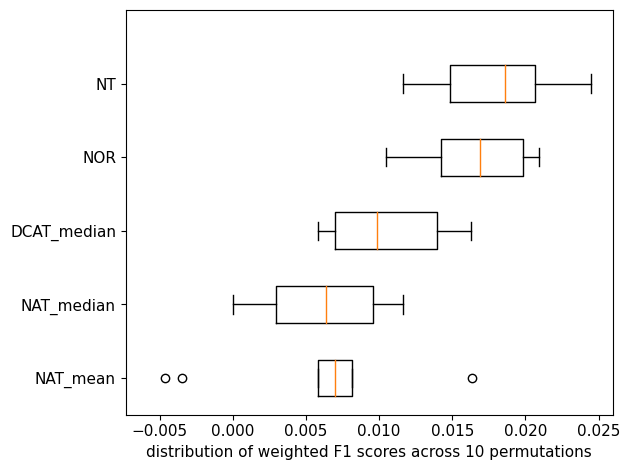

In [19]:
metric='f1_weighted'
cols_rename={'feat_num_activity_type':'NT',
             'feat_owner':'NOR',
             'activity_per_act_type_mean':'NAT_mean',
             'time_to_switch_act_type_50%':'DCAT_median',
             'activity_per_act_type_50%':'NAT_median',
             'feat_ratio_owner_repo':'ORR',
             'consecutive_activity_time_50%':'DCA_median',
             'time_to_switch_act_type_std':'DCAT_std',
             'time_to_switch_repo_50%':'DAAR_median',
             'activity_type_per_repo_mean':'NTR_mean',
             'activity_type_per_repo_std':'NTR_std'}

fimp_sorted_idx = feature_importance[metric].importances_mean.argsort()
plt.boxplot(feature_importance['f1_weighted'].importances[fimp_sorted_idx].T,
            vert=False,
            labels=x_test_impt.rename(columns=cols_rename).keys()[fimp_sorted_idx])
plt.xlabel(xlabel='distribution of weighted F1 scores across 10 permutations',fontsize=11)
plt.ylim(33.5,39)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
# plt.savefig('../../notebooks_scripts/Plots/feature_importance_test.pdf')
plt.show()

In [20]:
def myMannWhitneyU(df, feature, val1='bot', val2='human', alpha=0.001/38):
    '''
    args: df - DataFrame; dataframe that needs to be processed
          feature - str; the feature that needs to be analysed
          sep_field - str; the field on which the dataframe has to be divided
          val1 - str; the value of the 1st field to get the list of numbers corresponding to that value
          val2 - str; the value of the 2nd field to get the list of numbers corresponding to that value
          alpha - float; the level of significance
    
    return: p - float; the probability value
            stat - float; the statistic U
            decision - str; the decision if null hypothesis is rejected or not
            d - float; the cliffs delta's difference value
            size - str; the size cliff's delta's difference - negligible, small, medium, large
    
    Method: perform Mann Whitney U test and report the effect size
    '''
    
    set1 = df.query('bot == @val1')[feature].dropna()
    set2 = df.query('bot == @val2')[feature].dropna()
    stat, p = mannwhitneyu(set1, set2)
    
    d,size=cd.cliffsDelta(set1,set2)
    if p<alpha:
        decision = f'With alpha={alpha}, Reject null hypothesis - They have significant difference'
    else:
        decision = f'With alpha={alpha}, Null hypothesis (They have significant difference) cannot be rejected'
    
    bot_med = set1.describe()['50%']
    hum_med = set2.describe()['50%']
    return(p, stat, decision, d, size, bot_med, hum_med)

In [21]:
## median value for the observed important features
df_test_set = x_test_impt.merge(y_test, left_index=True, right_index=True, how='inner')
# plot_features = df_important_features.keys().to_list()
plot_features = ['NT',
                 'NOR',
                 'DCAT_median',
                 'NAT_median',
                 'NAT_mean']
for plot_feature in plot_features:
    set_bot = df_test_set.query('bot == 1')[plot_feature].dropna()
    set_hum = df_test_set.query('bot == 0')[plot_feature].dropna()
    pv, stat, decision, d, size, bot_med, human_med = myMannWhitneyU(df_test_set, plot_feature, 1, 0)
    # d,size=cd.cliffsDelta(set_bot,set_hum)
    
    print(f"{plot_feature}")
    print(f'p-value: {pv}, decision: {decision}')
    print(f"delta: {d}, size: {size}")
    print(f"median values: \nbot: {bot_med}, \
    human: {human_med}\n")

NT
p-value: 5.3884786963570784e-76, decision: With alpha=2.6315789473684212e-05, Reject null hypothesis - They have significant difference
delta: -0.7247893243213969, size: large
median values: 
bot: 4.0,     human: 10.0

NOR
p-value: 2.4680777583987033e-47, decision: With alpha=2.6315789473684212e-05, Reject null hypothesis - They have significant difference
delta: -0.5544615584584389, size: large
median values: 
bot: 1.0,     human: 4.0

DCAT_median
p-value: 1.532716588651118e-30, decision: With alpha=2.6315789473684212e-05, Reject null hypothesis - They have significant difference
delta: -0.48153009050392365, size: large
median values: 
bot: 0.003,     human: 0.125

NAT_median
p-value: 5.231829043730823e-66, decision: With alpha=2.6315789473684212e-05, Reject null hypothesis - They have significant difference
delta: 0.6761985225623361, size: large
median values: 
bot: 29.5,     human: 6.0

NAT_mean
p-value: 3.918338314363224e-71, decision: With alpha=2.6315789473684212e-05, Reject n

## Visualising distribution of TP, TN, FP and FN in terms of features

In [22]:
def myMannWhitneyU_cliffsdelta(df, feature, val1='bot', val2='human', alpha=0.01):
    '''
    args: df - DataFrame; dataframe that needs to be processed
          feature - str; the feature that needs to be analysed
          sep_field - str; the field on which the dataframe has to be divided
          val1 - str; the value of the 1st field to get the list of numbers corresponding to that value
          val2 - str; the value of the 2nd field to get the list of numbers corresponding to that value
          alpha - float; the level of significance
    
    return: p - float; the probability value
            stat - float; the statistic U
            decision - str; the decision if null hypothesis is rejected or not
            d - float; the cliffs delta's difference value
            size - str; the size cliff's delta's difference - negligible, small, medium, large
    
    Method: perform Mann Whitney U test and report the effect size
    '''
    
    set1 = df.query('conf == @val1')[feature].dropna().to_list()
    set2 = df.query('conf == @val2')[feature].dropna().to_list()
    stat, p = mannwhitneyu(set1, set2)
    
    d,size=cd.cliffsDelta(set1,set2)
    if p<alpha:
        decision = f'With alpha={alpha}, Reject null hypothesis - They have significant difference'
    else:
        decision = f'With alpha={alpha}, Null hypothesis (They have significant difference) cannot be rejected'
    return(p, stat, decision, d, size)

In [23]:
def conf_matrix(df_pred_gt):
    df_pred_gt = df_pred_gt.assign(conf=lambda d: np.where(((d.bot == 1) & (d.pred == 1)), 'TP',
                                                           np.where(((d.bot == 1) & (d.pred == 0)), 'FN', 
                                                                    np.where(((d.bot == 0) & (d.pred == 0)), 'TN', 
                                                                             np.where(((d.bot == 0) & (d.pred == 1)), 'FP', None))))
                                  )
    return(df_pred_gt)

In [24]:
x_test_impt_conf = (
    conf_matrix((x_test_impt.assign(pred = y_pred).join(y_test).join(ground_truth)))
    [x_test_impt.columns.to_list()+['bot','pred','conf']]
)
x_test_impt_conf

,NA,NT,NOR,ORR,DCA_mean,DCA_median,DCA_std,DCA_gini,NAR_mean,NAR_median,...,DCAT_gini,DCAT_IQR,NAT_mean,NAT_median,NAT_std,NAT_gini,NAT_IQR,bot,pred,conf
contributor,,,,,,,,,,,,,,,,,,,,,
otc-zuul[bot],185,5,4,0.182,1.937,0.000,7.485,0.892,8.409,5.5,...,0.895,0.153,37.000,57.0,31.161,0.385,54.00,1,1,TP
ljharb,245,16,31,0.492,0.932,0.059,2.618,0.846,3.889,2.0,...,0.855,0.472,15.312,7.0,20.480,0.608,11.75,0,0,TN
juancarlospaco,126,13,20,0.541,13.648,0.331,28.672,0.807,3.405,1.0,...,0.792,14.841,9.692,4.0,11.870,0.591,12.00,0,0,TN
tldr-bot,300,1,1,1.000,7.091,0.356,12.523,0.767,300.000,300.0,...,0.000,NaN,300.000,300.0,0.000,0.000,0.00,1,1,TP
jakirkham,262,12,18,0.273,0.219,0.024,1.036,0.869,3.970,2.0,...,0.878,0.089,21.833,8.0,30.322,0.601,17.50,0,0,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mmstick,259,11,2,0.095,1.960,0.051,6.153,0.872,12.333,5.0,...,0.880,0.698,23.545,20.0,19.922,0.397,15.50,0,0,TN
asyncapi-bot,298,4,1,0.333,0.009,0.003,0.069,0.676,99.333,4.0,...,0.366,0.459,74.500,2.0,145.670,0.737,74.50,1,1,TP
jeffgbutler,150,12,2,0.182,14.016,0.163,35.470,0.840,13.636,4.0,...,0.867,4.093,12.500,5.5,19.829,0.647,11.75,0,0,TN


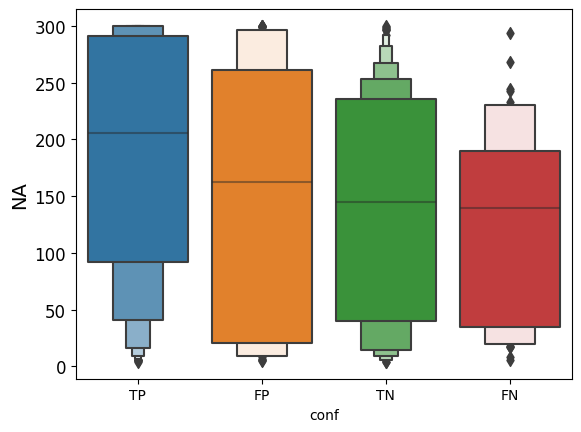

TP: mean=186.101, std=100.76, median=206.0
FP: mean=153.2, std=117.064, median=162.5
TN: mean=141.02, std=97.824, median=144.5
FN: mean=125.027, std=88.57, median=140.0

Between TP and FP 
p-value: 0.02959607578500919, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.1887533156498674, effect size: small
Between TN and FN 
p-value: 0.28765115355844817, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.10571935571935571, effect size: negligible
Between TP and FN 
p-value: 0.00024115592442193278, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.3646856405477095, effect size: medium
Between TN and FP 
p-value: 0.39919488365936695, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.07318181818181818, effect size: negligible


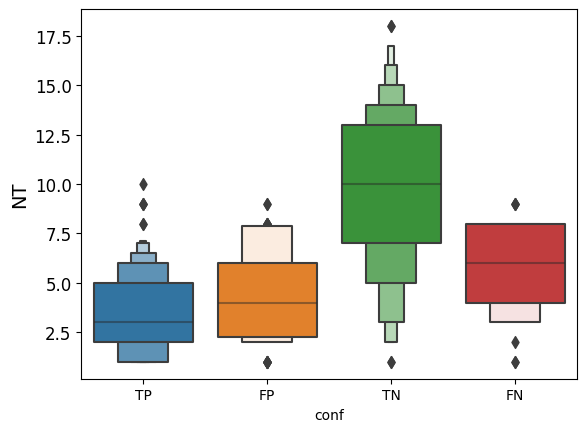

TP: mean=3.523, std=1.907, median=3.0
FP: mean=4.46, std=2.341, median=4.0
TN: mean=9.588, std=3.779, median=10.0
FN: mean=5.811, std=2.246, median=6.0

Between TP and FP 
p-value: 0.007680434608479743, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.22907161803713527, effect size: small
Between TN and FN 
p-value: 2.933965166556554e-09, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.587974337974338, effect size: large
Between TP and FN 
p-value: 1.6659977924653486e-08, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.5553803140010036, effect size: large
Between TN and FP 
p-value: 6.590164228568105e-17, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.7226262626262626, effect size: large


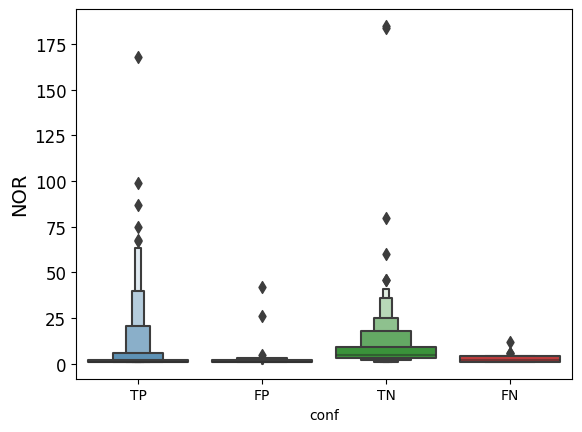

TP: mean=5.228, std=14.737, median=1.0
FP: mean=2.84, std=6.674, median=1.0
TN: mean=9.134, std=15.643, median=5.0
FN: mean=2.703, std=2.133, median=2.0

Between TP and FP 
p-value: 0.8422918611482835, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.014960212201591511, effect size: negligible
Between TN and FN 
p-value: 1.3388072531119e-08, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.5619028119028119, effect size: large
Between TP and FN 
p-value: 0.0013509310967526192, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.2795182450354864, effect size: small
Between TN and FP 
p-value: 1.305388168474386e-17, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.7374747474747475, effect size: large


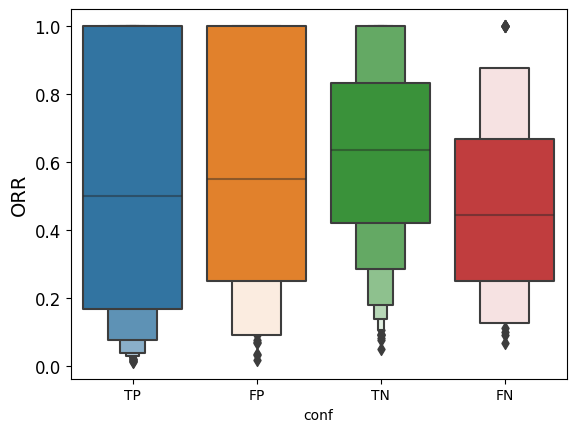

TP: mean=0.493, std=0.362, median=0.5
FP: mean=0.59, std=0.376, median=0.55
TN: mean=0.619, std=0.264, median=0.636
FN: mean=0.47, std=0.289, median=0.444

Between TP and FP 
p-value: 0.1059015671566813, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.1390450928381963, effect size: negligible
Between TN and FN 
p-value: 0.0018288786187685454, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.3088998088998089, effect size: small
Between TP and FN 
p-value: 0.8913052741077246, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.013549358376944584, effect size: negligible
Between TN and FP 
p-value: 0.7214494970093673, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.03085858585858586, effect size: negligible


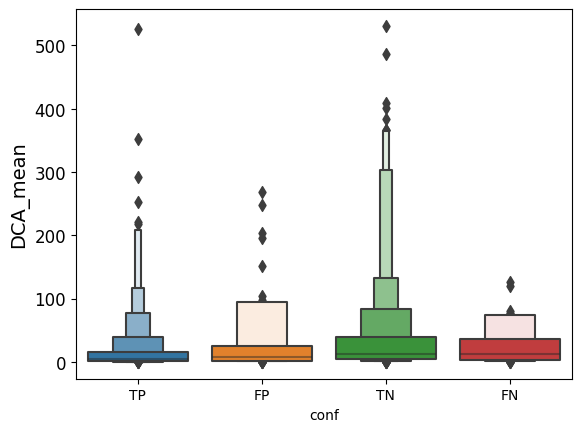

TP: mean=19.801, std=48.123, median=4.09
FP: mean=35.891, std=65.752, median=7.159
TN: mean=39.983, std=75.351, median=12.514
FN: mean=27.745, std=34.221, median=11.77

Between TP and FP 
p-value: 0.07709542108704247, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.15384615384615385, effect size: small
Between TN and FN 
p-value: 0.48828426067999575, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.06893256893256894, effect size: negligible
Between TP and FN 
p-value: 0.004361506364772506, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.28396300810093916, effect size: small
Between TN and FP 
p-value: 0.03168767767324954, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.18641414141414142, effect size: small


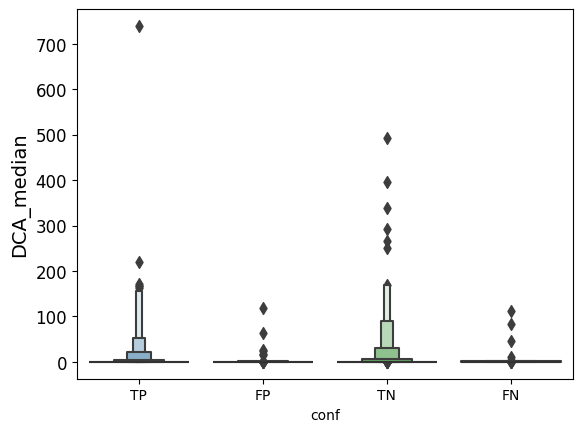

TP: mean=7.685, std=44.72, median=0.016
FP: mean=5.546, std=19.388, median=0.07
TN: mean=10.553, std=46.784, median=0.129
FN: mean=7.179, std=23.332, median=0.194

Between TP and FP 
p-value: 0.035409562410456084, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.1823342175066313, effect size: small
Between TN and FN 
p-value: 0.9550842989403271, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.005664755664755665, effect size: negligible
Between TP and FN 
p-value: 0.003419935634265452, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.2904150835185318, effect size: small
Between TN and FP 
p-value: 0.017501010553666728, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.20616161616161616, effect size: small


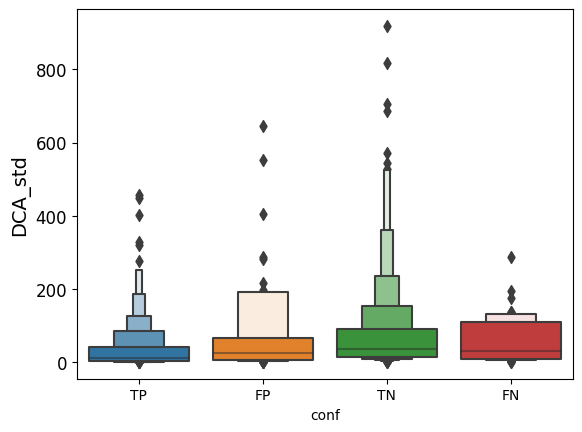

TP: mean=35.277, std=62.015, median=10.063
FP: mean=77.528, std=137.936, median=25.054
TN: mean=75.678, std=114.543, median=34.618
FN: mean=60.502, std=67.316, median=29.142

Between TP and FP 
p-value: 0.03492064641364383, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.18355437665782492, effect size: small
Between TN and FN 
p-value: 0.4332128737542196, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.07794157794157794, effect size: negligible
Between TP and FN 
p-value: 0.0018397201187349294, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.31027313785934474, effect size: small
Between TN and FP 
p-value: 0.03363187086779331, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.18434343434343434, effect size: small


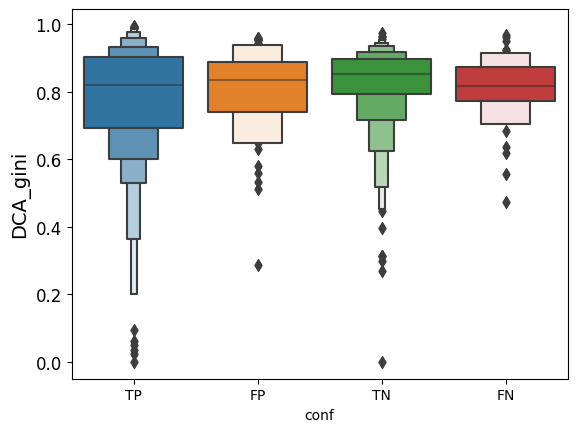

TP: mean=0.776, std=0.173, median=0.819
FP: mean=0.801, std=0.138, median=0.835
TN: mean=0.822, std=0.12, median=0.851
FN: mean=0.809, std=0.109, median=0.816

Between TP and FP 
p-value: 0.48732917444399837, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.060477453580901855, effect size: negligible
Between TN and FN 
p-value: 0.2080155792162186, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.12517062517062516, effect size: negligible
Between TP and FN 
p-value: 0.604230409493799, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.05168829306760341, effect size: negligible
Between TN and FP 
p-value: 0.385029336917196, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.0754040404040404, effect size: negligible


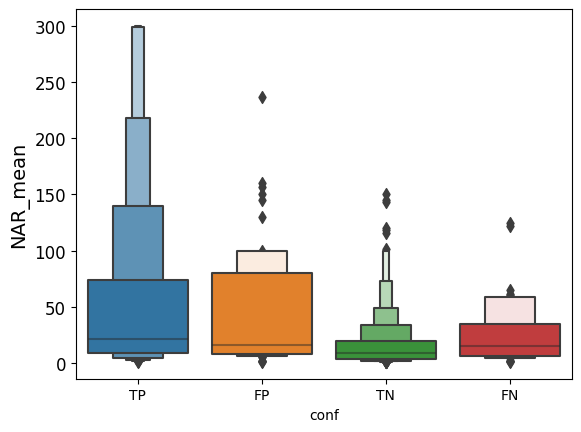

TP: mean=55.914, std=74.507, median=21.429
FP: mean=45.297, std=55.063, median=15.71
TN: mean=16.362, std=21.736, median=9.099
FN: mean=26.387, std=30.164, median=14.75

Between TP and FP 
p-value: 0.5484684489383276, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.052254641909814326, effect size: negligible
Between TN and FN 
p-value: 0.021121739046985125, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.22918372918372917, effect size: small
Between TP and FN 
p-value: 0.03854432994093171, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.2061079647286544, effect size: small
Between TN and FP 
p-value: 8.727424629375657e-05, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.34040404040404043, effect size: medium


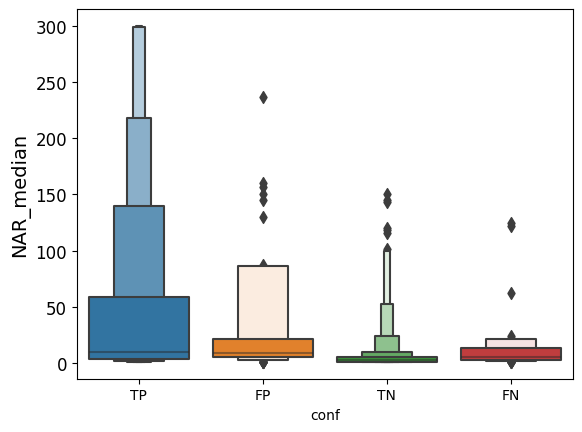

TP: mean=48.552, std=76.629, median=10.0
FP: mean=32.93, std=53.47, median=9.0
TN: mean=7.958, std=19.397, median=2.75
FN: mean=14.946, std=28.513, median=5.0

Between TP and FP 
p-value: 0.6349837574549595, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.0413262599469496, effect size: negligible
Between TN and FN 
p-value: 0.0005610366140880306, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.3387250887250887, effect size: medium
Between TP and FN 
p-value: 0.003131292217435775, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.29407125958850094, effect size: small
Between TN and FP 
p-value: 1.5852143825530589e-10, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.5488383838383838, effect size: large


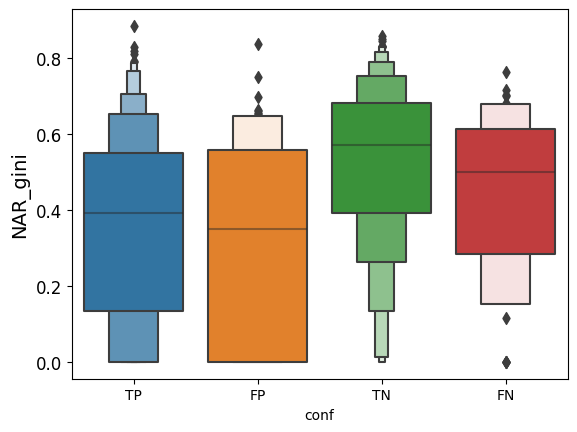

TP: mean=0.355, std=0.249, median=0.393
FP: mean=0.316, std=0.273, median=0.35
TN: mean=0.524, std=0.21, median=0.57
FN: mean=0.447, std=0.224, median=0.5

Between TP and FP 
p-value: 0.3635527982566902, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.07862068965517241, effect size: negligible
Between TN and FN 
p-value: 0.034496662313019934, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.21014196014196015, effect size: small
Between TP and FN 
p-value: 0.025904314341946094, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.2209477381891175, effect size: small
Between TN and FP 
p-value: 2.9985670116608853e-07, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.4444444444444444, effect size: medium


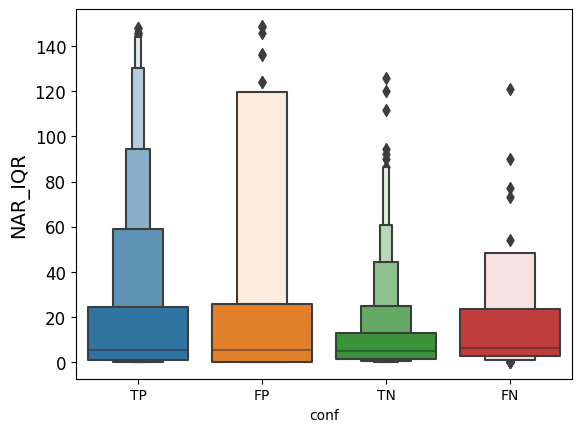

TP: mean=20.953, std=33.788, median=5.5
FP: mean=30.095, std=49.099, median=5.5
TN: mean=11.777, std=18.607, median=5.0
FN: mean=19.628, std=28.798, median=6.25

Between TP and FP 
p-value: 0.5723597900896709, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.048753315649867374, effect size: negligible
Between TN and FN 
p-value: 0.1886083096468535, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.13056238056238056, effect size: negligible
Between TP and FN 
p-value: 0.42909807540003364, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.07835687146031974, effect size: negligible
Between TN and FP 
p-value: 0.6378386528670107, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.04080808080808081, effect size: negligible


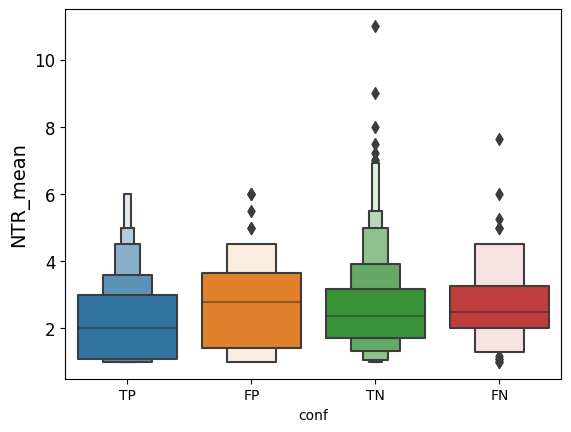

TP: mean=2.221, std=1.211, median=2.0
FP: mean=2.776, std=1.49, median=2.769
TN: mean=2.622, std=1.324, median=2.375
FN: mean=2.783, std=1.483, median=2.5

Between TP and FP 
p-value: 0.011905173716208356, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.21729442970822282, effect size: small
Between TN and FN 
p-value: 0.6517387781341984, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.04490854490854491, effect size: negligible
Between TP and FN 
p-value: 0.008470709913948209, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.2605921571438813, effect size: small
Between TN and FP 
p-value: 0.6247100001523773, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.04247474747474748, effect size: negligible


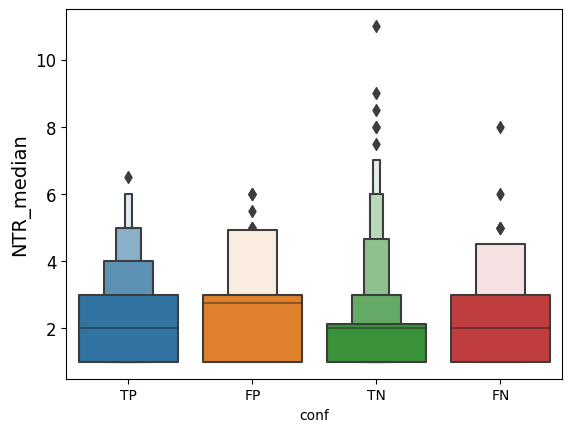

TP: mean=2.16, std=1.312, median=2.0
FP: mean=2.68, std=1.548, median=2.75
TN: mean=2.057, std=1.447, median=2.0
FN: mean=2.5, std=1.654, median=2.0

Between TP and FP 
p-value: 0.021189897007202845, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.19246684350132626, effect size: small
Between TN and FN 
p-value: 0.07221142569143087, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.17062517062517063, effect size: small
Between TP and FN 
p-value: 0.26278291653107344, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.10696107247831385, effect size: negligible
Between TN and FP 
p-value: 0.0018737738418183115, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.2582828282828283, effect size: small


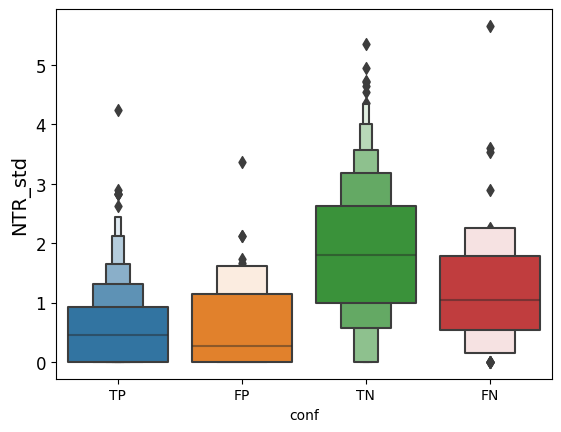

TP: mean=0.551, std=0.669, median=0.447
FP: mean=0.651, std=0.785, median=0.269
TN: mean=1.831, std=1.118, median=1.804
FN: mean=1.336, std=1.166, median=1.047

Between TP and FP 
p-value: 0.4865075862157161, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.05777188328912467, effect size: negligible
Between TN and FN 
p-value: 0.003424508866030986, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.2908135408135408, effect size: small
Between TP and FN 
p-value: 6.476382660390663e-07, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.4768800630869596, effect size: large
Between TN and FP 
p-value: 2.0446116484537384e-12, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.6094949494949495, effect size: large


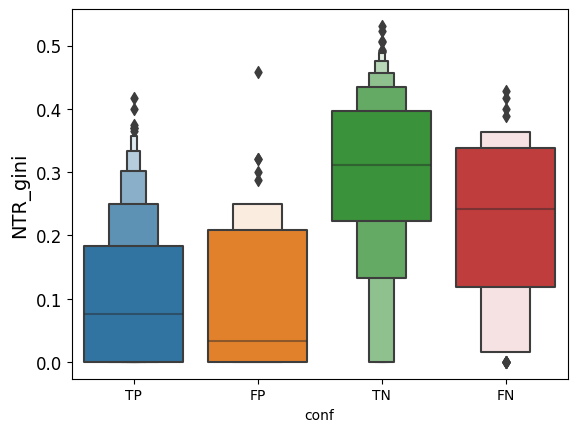

TP: mean=0.103, std=0.113, median=0.075
FP: mean=0.103, std=0.122, median=0.034
TN: mean=0.293, std=0.132, median=0.311
FN: mean=0.218, std=0.133, median=0.241

Between TP and FP 
p-value: 0.9632687968228003, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.0038726790450928383, effect size: negligible
Between TN and FN 
p-value: 0.0008784440962781884, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.3305350805350805, effect size: medium
Between TP and FN 
p-value: 3.449358814088569e-07, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.48842210911176426, effect size: large
Between TN and FP 
p-value: 1.9355935673512127e-15, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.6886868686868687, effect size: large


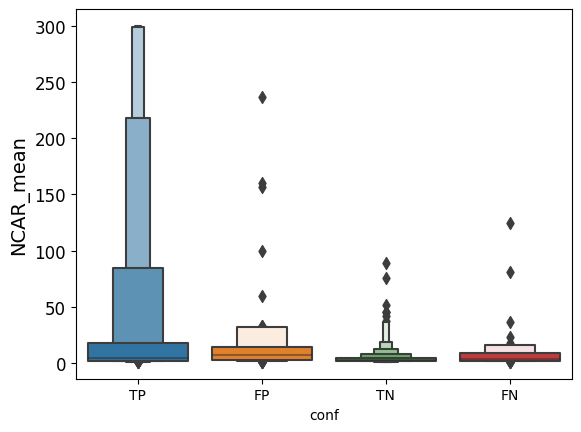

TP: mean=34.653, std=74.114, median=4.081
FP: mean=22.032, std=45.591, median=6.857
TN: mean=5.055, std=8.249, median=2.692
FN: mean=11.565, std=23.909, median=3.625

Between TP and FP 
p-value: 0.18052880044505826, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.11655172413793104, effect size: negligible
Between TN and FN 
p-value: 0.07926886149544764, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.17444717444717445, effect size: small
Between TP and FN 
p-value: 0.39241772004522957, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.08523908523908524, effect size: negligible
Between TN and FP 
p-value: 9.010479649796734e-07, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.4261616161616162, effect size: medium


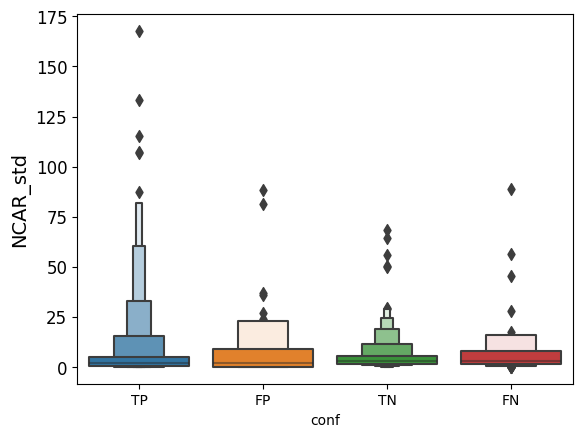

TP: mean=7.793, std=19.068, median=1.722
FP: mean=9.365, std=18.353, median=1.71
TN: mean=5.731, std=8.311, median=2.999
FN: mean=9.772, std=18.05, median=2.768

Between TP and FP 
p-value: 0.8084466184690733, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.021007957559681698, effect size: negligible
Between TN and FN 
p-value: 0.9364925280566374, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.007985257985257985, effect size: negligible
Between TP and FN 
p-value: 0.037949366505138346, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.20582120582120583, effect size: small
Between TN and FP 
p-value: 0.030966669008705847, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.18717171717171718, effect size: small


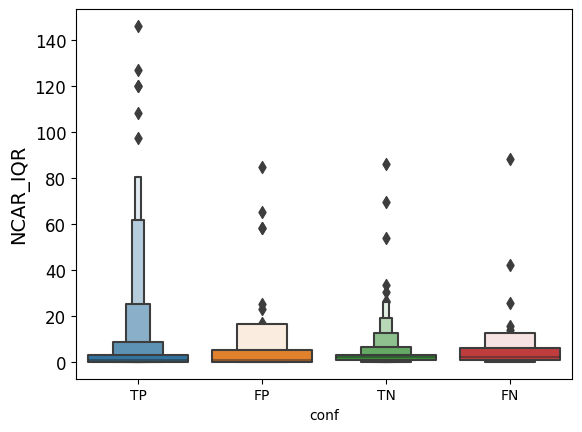

TP: mean=6.428, std=18.47, median=1.0
FP: mean=8.24, std=18.43, median=1.0
TN: mean=3.704, std=7.575, median=2.0
FN: mean=7.135, std=15.955, median=2.0

Between TP and FP 
p-value: 0.9230841952284029, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.008222811671087533, effect size: negligible
Between TN and FN 
p-value: 0.441812635211125, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.07562107562107562, effect size: negligible
Between TP and FN 
p-value: 0.04810959181190825, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.19212846799053696, effect size: small
Between TN and FP 
p-value: 0.16606371758382021, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.11883838383838384, effect size: negligible


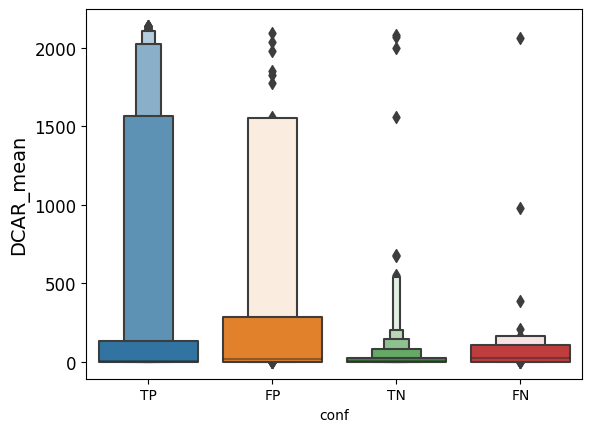

TP: mean=329.375, std=678.381, median=5.982
FP: mean=387.096, std=700.439, median=20.993
TN: mean=51.273, std=204.858, median=6.428
FN: mean=136.276, std=368.157, median=23.444

Between TP and FP 
p-value: 0.11720442587894542, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.1363395225464191, effect size: negligible
Between TN and FN 
p-value: 0.08009512489084457, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.17396942396942397, effect size: small
Between TP and FN 
p-value: 0.39360851763587135, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.08502401605849881, effect size: negligible
Between TN and FP 
p-value: 0.007236871119162299, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.23303030303030303, effect size: small


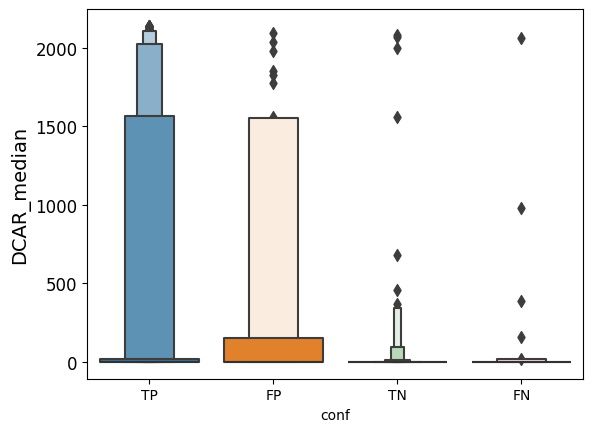

TP: mean=310.561, std=684.09, median=0.001
FP: mean=373.801, std=706.23, median=0.35
TN: mean=27.015, std=199.612, median=0.0
FN: mean=98.493, std=374.165, median=0.003

Between TP and FP 
p-value: 0.01742007171635826, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.19984084880636604, effect size: small
Between TN and FN 
p-value: 0.01378572510693266, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.21996996996996998, effect size: small
Between TP and FN 
p-value: 0.6092722232546588, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.04889239371997993, effect size: negligible
Between TN and FP 
p-value: 1.4129811742996462e-09, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.4796969696969697, effect size: large


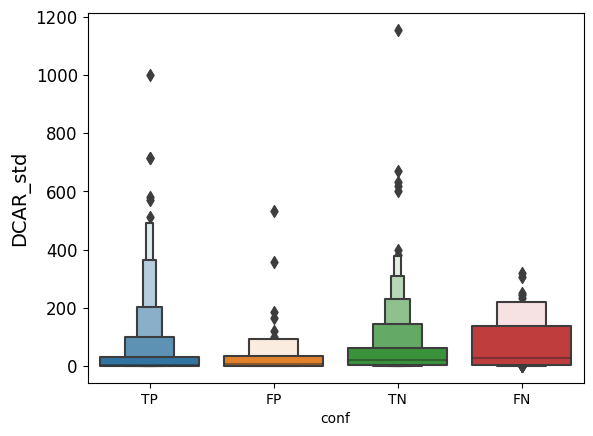

TP: mean=45.103, std=113.615, median=1.855
FP: mean=44.108, std=94.849, median=6.386
TN: mean=60.354, std=110.571, median=21.376
FN: mean=79.6, std=99.051, median=26.561

Between TP and FP 
p-value: 0.9191636836499069, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.008806366047745358, effect size: negligible
Between TN and FN 
p-value: 0.7369515872822554, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.033442533442533444, effect size: negligible
Between TP and FN 
p-value: 0.0007839377755367369, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.3324252634597462, effect size: medium
Between TN and FP 
p-value: 0.0013198702802463252, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.2785858585858586, effect size: small


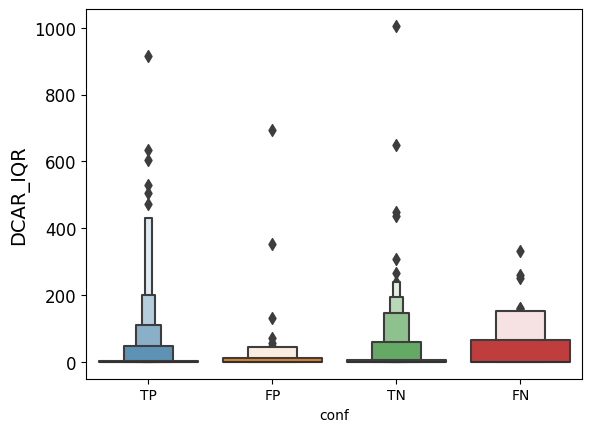

TP: mean=25.348, std=90.203, median=0.002
FP: mean=31.291, std=109.935, median=0.016
TN: mean=26.173, std=83.142, median=0.23
FN: mean=49.011, std=84.083, median=0.451

Between TP and FP 
p-value: 0.47269205570327877, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.06021220159151194, effect size: negligible
Between TN and FN 
p-value: 0.1670676467808231, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.13690963690963692, effect size: negligible
Between TP and FN 
p-value: 0.00035561644873572415, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.3443974478457237, effect size: medium
Between TN and FP 
p-value: 0.08564289439202448, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.14843434343434345, effect size: small


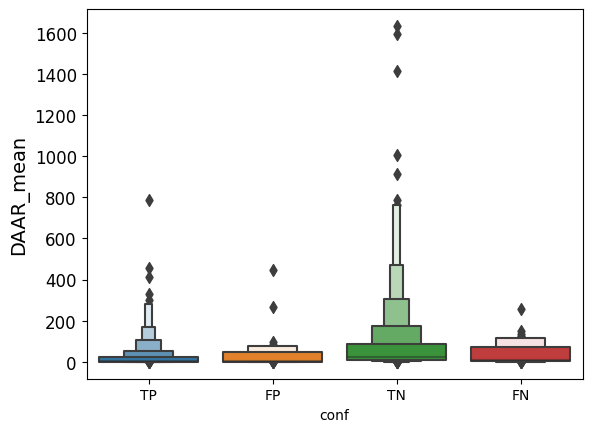

TP: mean=27.953, std=72.187, median=4.6
FP: mean=39.476, std=87.223, median=4.119
TN: mean=86.654, std=184.381, median=25.125
FN: mean=43.719, std=59.279, median=10.928

Between TP and FP 
p-value: 0.6008392841180544, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.05416065416065416, effect size: negligible
Between TN and FN 
p-value: 0.07197451225162613, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.18607288673824285, effect size: small
Between TP and FN 
p-value: 0.008379132553380228, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.2760942760942761, effect size: small
Between TN and FP 
p-value: 0.00012857137001763053, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.3906720528828498, effect size: medium


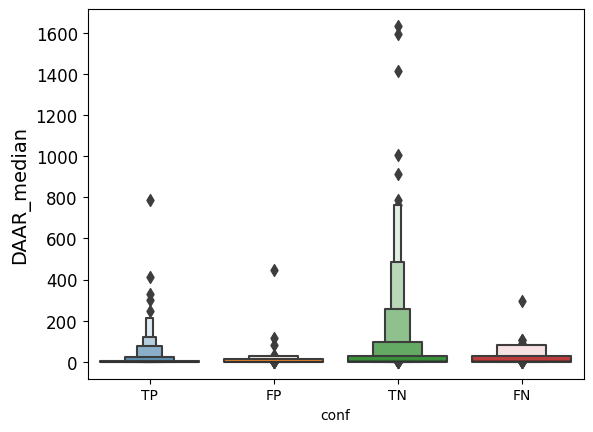

TP: mean=16.96, std=64.024, median=0.462
FP: mean=23.615, std=77.434, median=0.389
TN: mean=59.424, std=183.734, median=2.899
FN: mean=27.929, std=57.828, median=2.422

Between TP and FP 
p-value: 0.5530839433212562, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.061375661375661375, effect size: negligible
Between TN and FN 
p-value: 0.4010966724045685, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.08687433842431574, effect size: negligible
Between TP and FN 
p-value: 0.020963563592057182, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.2417310358486829, effect size: small
Between TN and FP 
p-value: 0.0033444006999355015, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.2993756885787734, effect size: small


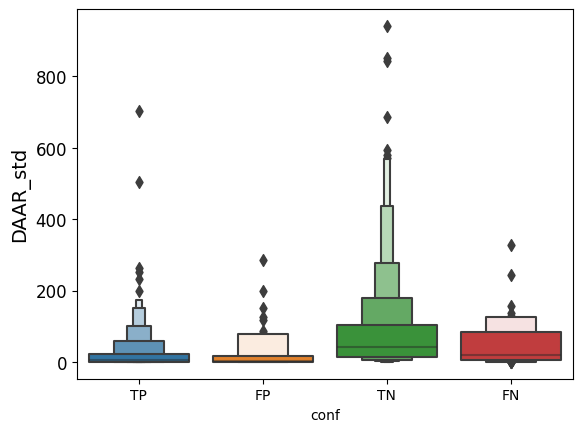

TP: mean=25.11, std=59.14, median=4.434
FP: mean=28.147, std=57.503, median=3.638
TN: mean=86.09, std=126.913, median=42.356
FN: mean=54.229, std=73.406, median=18.869

Between TP and FP 
p-value: 0.43489579817697865, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.06753315649867374, effect size: negligible
Between TN and FN 
p-value: 0.03385491947614204, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.2108927108927109, effect size: small
Between TP and FN 
p-value: 0.00045583576052296283, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.34748010610079577, effect size: medium
Between TN and FP 
p-value: 2.4841521239522375e-10, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.5488888888888889, effect size: large


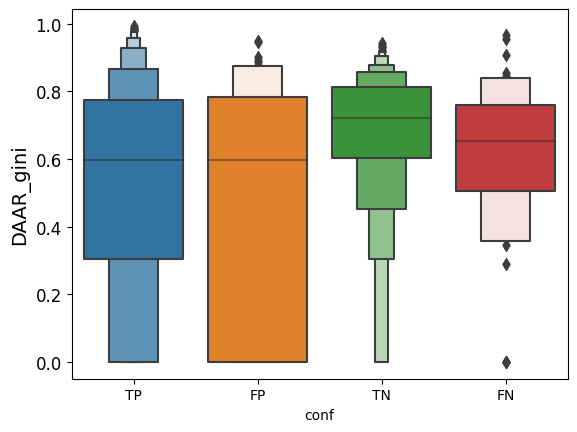

TP: mean=0.52, std=0.326, median=0.597
FP: mean=0.458, std=0.368, median=0.596
TN: mean=0.668, std=0.21, median=0.722
FN: mean=0.605, std=0.244, median=0.655

Between TP and FP 
p-value: 0.4700584585438109, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.06249336870026525, effect size: negligible
Between TN and FN 
p-value: 0.05574840168571992, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.19014469014469015, effect size: small
Between TP and FN 
p-value: 0.2956411496830814, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.10373503476951752, effect size: negligible
Between TN and FP 
p-value: 0.0013019871357427472, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.27893939393939393, effect size: small


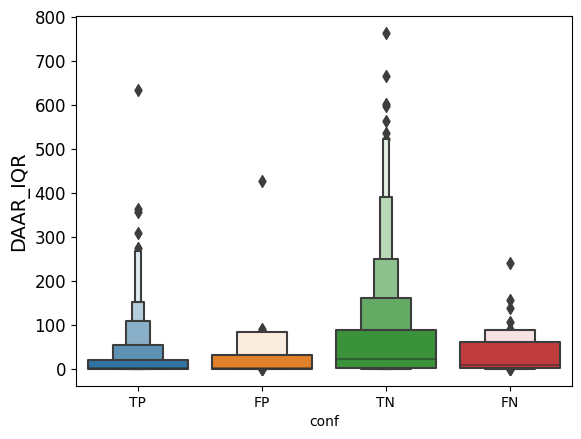

TP: mean=24.686, std=62.359, median=2.312
FP: mean=31.717, std=75.236, median=2.636
TN: mean=69.545, std=115.833, median=21.536
FN: mean=36.543, std=55.648, median=8.36

Between TP and FP 
p-value: 0.7771589141378699, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.02934102934102934, effect size: negligible
Between TN and FN 
p-value: 0.053762044777866766, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.19945561772266748, effect size: small
Between TP and FN 
p-value: 0.020828744094029867, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.24202812438106555, effect size: small
Between TN and FP 
p-value: 0.00021593593735947262, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.37745134043334555, effect size: medium


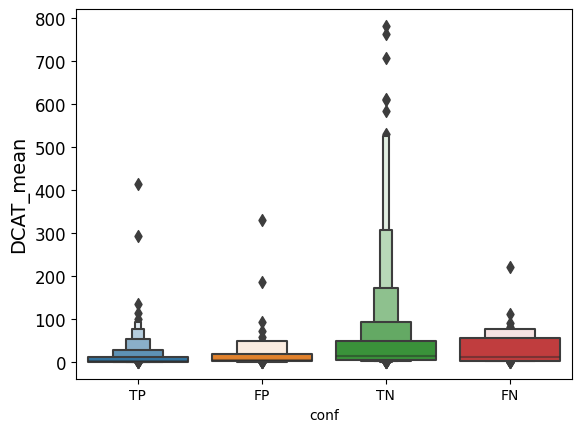

TP: mean=13.362, std=34.798, median=2.758
FP: mean=24.732, std=57.532, median=4.982
TN: mean=49.779, std=106.119, median=13.462
FN: mean=33.498, std=45.543, median=12.199

Between TP and FP 
p-value: 0.06612079334772807, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.17163271511097597, effect size: small
Between TN and FN 
p-value: 0.5932199152853114, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.05453226976069615, effect size: negligible
Between TP and FN 
p-value: 8.605624207498693e-05, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.40573339703774486, effect size: medium
Between TN and FP 
p-value: 0.0006410947704475175, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.313682510383018, effect size: small


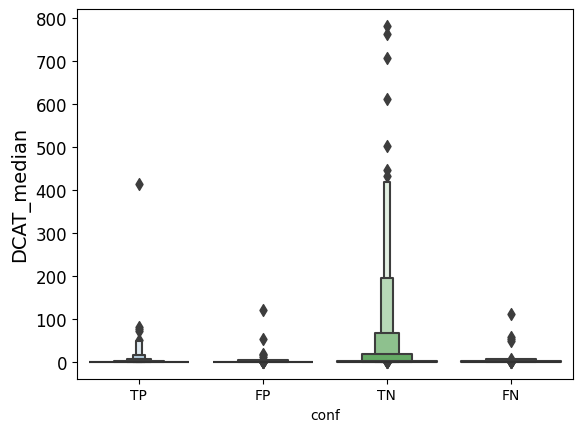

TP: mean=3.392, std=25.425, median=0.001
FP: mean=5.245, std=19.751, median=0.035
TN: mean=21.197, std=89.43, median=0.134
FN: mean=8.454, std=23.36, median=0.143

Between TP and FP 
p-value: 1.993254353649832e-05, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.39358467619337184, effect size: medium
Between TN and FN 
p-value: 0.5621125510629938, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.05917331399564902, effect size: negligible
Between TP and FN 
p-value: 6.153666596312578e-07, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.5091256569517439, effect size: large
Between TN and FP 
p-value: 0.002370016721522214, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.27930318412551913, effect size: small


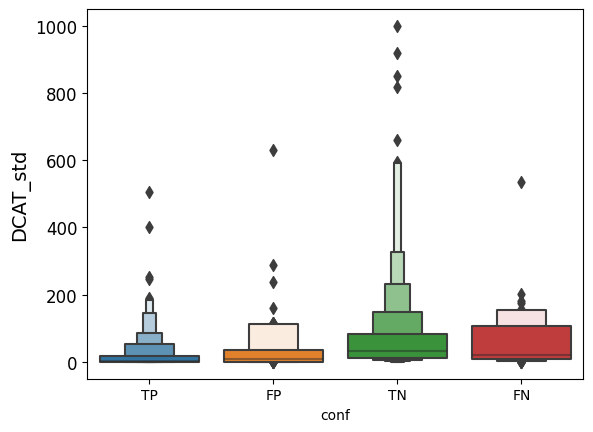

TP: mean=21.936, std=49.694, median=4.02
FP: mean=46.974, std=103.642, median=7.972
TN: mean=73.712, std=123.586, median=33.748
FN: mean=67.277, std=100.128, median=21.558

Between TP and FP 
p-value: 0.022333828412972163, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.19787798408488064, effect size: small
Between TN and FN 
p-value: 0.39551918642239325, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.08449358449358449, effect size: negligible
Between TP and FN 
p-value: 4.8385952651713546e-06, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.45329414294931536, effect size: medium
Between TN and FP 
p-value: 2.66123237904792e-05, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.36444444444444446, effect size: medium


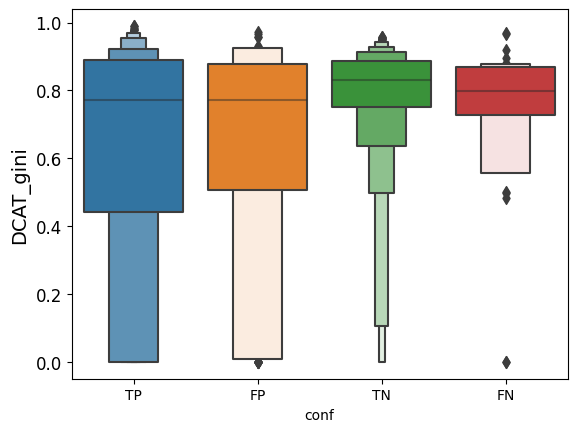

TP: mean=0.619, std=0.353, median=0.773
FP: mean=0.643, std=0.321, median=0.773
TN: mean=0.777, std=0.19, median=0.831
FN: mean=0.744, std=0.214, median=0.799

Between TP and FP 
p-value: 0.9824084857395153, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.0019628647214854113, effect size: negligible
Between TN and FN 
p-value: 0.13936520121337298, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.14694239694239694, effect size: negligible
Between TP and FN 
p-value: 0.42278402382724223, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.07957559681697612, effect size: negligible
Between TN and FP 
p-value: 0.015138450333895605, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.21075757575757575, effect size: small


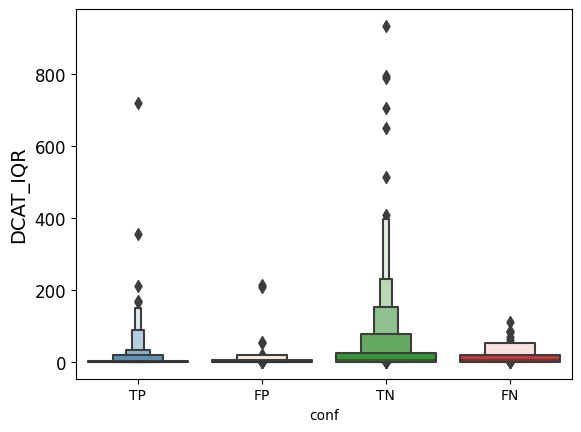

TP: mean=11.994, std=52.466, median=0.252
FP: mean=14.779, std=45.033, median=1.049
TN: mean=38.769, std=104.071, median=4.154
FN: mean=17.631, std=28.747, median=5.749

Between TP and FP 
p-value: 0.029929850146871887, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.20272119185162663, effect size: small
Between TN and FN 
p-value: 0.7194451541304299, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.03669325598259608, effect size: negligible
Between TP and FN 
p-value: 2.054139359911457e-05, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.43994266602962256, effect size: medium
Between TN and FP 
p-value: 0.0007876258263176412, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.3084910013844024, effect size: small


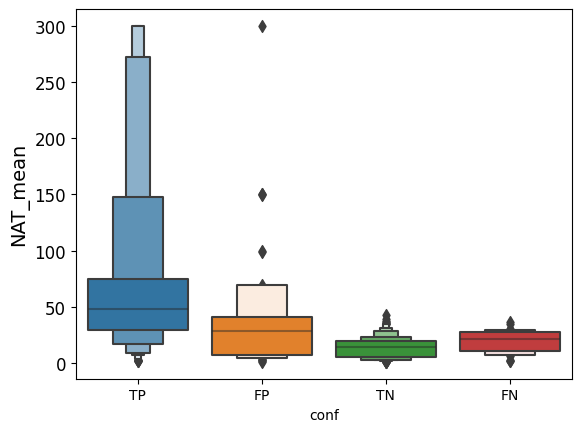

TP: mean=70.997, std=71.815, median=48.0
FP: mean=40.819, std=52.53, median=28.714
TN: mean=13.697, std=8.897, median=14.502
FN: mean=19.678, std=9.857, median=21.375

Between TP and FP 
p-value: 5.973772190281575e-06, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.39384615384615385, effect size: medium
Between TN and FN 
p-value: 0.0003669460860906454, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.3540813540813541, effect size: medium
Between TP and FN 
p-value: 1.2474943030900586e-11, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.6746003297727435, effect size: large
Between TN and FP 
p-value: 5.561838965795783e-07, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.4342929292929293, effect size: medium


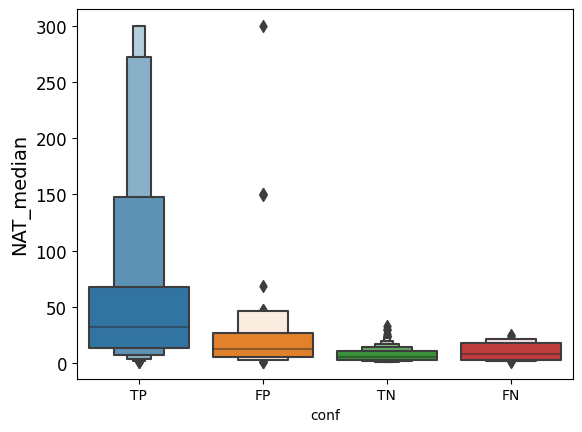

TP: mean=60.29, std=75.747, median=32.0
FP: mean=29.25, std=52.602, median=12.75
TN: mean=7.027, std=5.663, median=5.5
FN: mean=10.878, std=8.04, median=8.0

Between TP and FP 
p-value: 1.9925917385544064e-06, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.41358090185676394, effect size: medium
Between TN and FN 
p-value: 0.007145969347639919, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.2667895167895168, effect size: small
Between TP and FN 
p-value: 2.2067644141595913e-10, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.6319449422897698, effect size: large
Between TN and FP 
p-value: 1.2462473203496528e-06, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.41984848484848486, effect size: medium


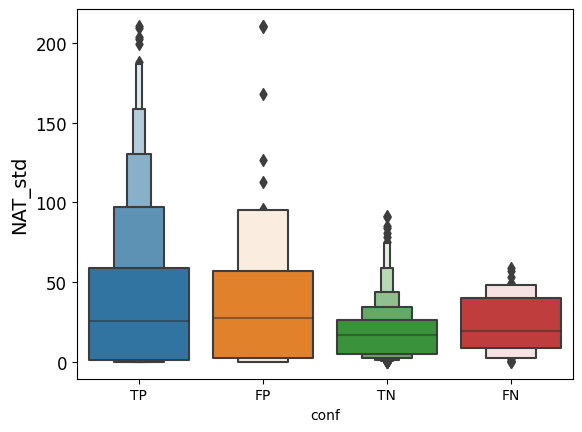

TP: mean=40.743, std=46.759, median=25.864
FP: mean=43.38, std=56.706, median=27.607
TN: mean=18.851, std=16.594, median=17.091
FN: mean=24.035, std=18.315, median=19.655

Between TP and FP 
p-value: 0.9262027640867805, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.00806366047745358, effect size: negligible
Between TN and FN 
p-value: 0.11228129574578408, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.15786240786240785, effect size: small
Between TP and FN 
p-value: 0.40605532485649065, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.08237149616459961, effect size: negligible
Between TN and FP 
p-value: 0.09450262124952041, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.1451010101010101, effect size: negligible


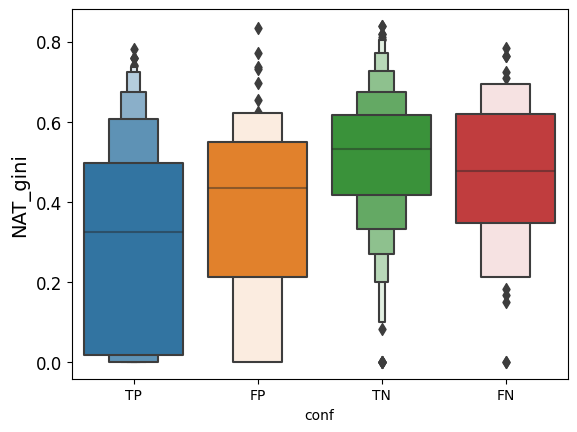

TP: mean=0.306, std=0.239, median=0.325
FP: mean=0.377, std=0.24, median=0.435
TN: mean=0.511, std=0.155, median=0.532
FN: mean=0.463, std=0.205, median=0.477

Between TP and FP 
p-value: 0.051689104734919174, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.1683289124668435, effect size: small
Between TN and FN 
p-value: 0.2004307056742337, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.1272863772863773, effect size: negligible
Between TP and FN 
p-value: 0.00018273791397996865, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.3707075776041293, effect size: medium
Between TN and FP 
p-value: 0.0001027624563416157, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.336969696969697, effect size: medium


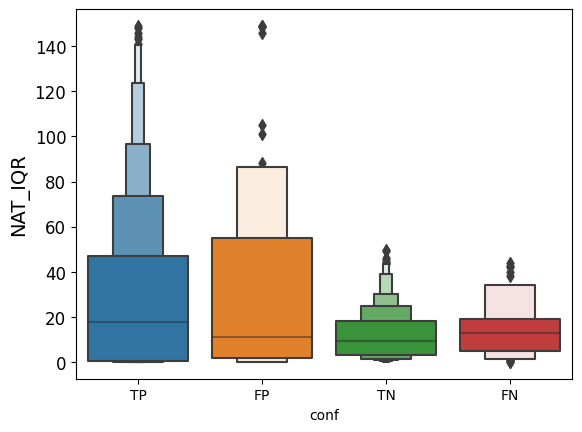

TP: mean=30.125, std=35.429, median=17.75
FP: mean=34.895, std=44.452, median=11.0
TN: mean=11.995, std=10.65, median=9.375
FN: mean=15.568, std=13.243, median=13.0

Between TP and FP 
p-value: 0.732041950120595, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.029655172413793104, effect size: negligible
Between TN and FN 
p-value: 0.1763647633793568, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.13438438438438438, effect size: negligible
Between TP and FN 
p-value: 0.29713903653292284, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: 0.10330489640834468, effect size: negligible
Between TN and FP 
p-value: 0.1252075651363815, decision: With alpha=0.01, Null hypothesis (They have significant difference) cannot be rejected, 
cliff's delta: -0.13303030303030303, effect size: negligible


In [25]:
for impt in x_test_impt.columns.to_list():
    sns.boxenplot(x_test_impt_conf[[impt,'bot','conf']], y=impt, x='conf',order=['TP', 'FP', 'TN', 'FN'])
    # sns.scatterplot(x=0, y=impt, data=FP, marker='x', color='red')
    # sns.scatterplot(x=2, y=impt, data=FN, marker='x', color='blue')
    # plt.legend(title=None,fontsize=9)
    plt.ylabel(impt, fontsize=14)
    plt.yticks(fontsize=12)
    plt.show()

    mean_TP=round(x_test_impt_conf.query('conf=="TP"')[impt].mean(),3)
    std_TP=round(x_test_impt_conf.query('conf=="TP"')[impt].std(),3)
    med_TP=round(x_test_impt_conf.query('conf=="TP"')[impt].median(),3)
    mean_FP=round(x_test_impt_conf.query('conf=="FP"')[impt].mean(),3)
    std_FP=round(x_test_impt_conf.query('conf=="FP"')[impt].std(),3)
    med_FP=round(x_test_impt_conf.query('conf=="FP"')[impt].median(),3)
    mean_TN=round(x_test_impt_conf.query('conf=="TN"')[impt].mean(),3)
    std_TN=round(x_test_impt_conf.query('conf=="TN"')[impt].std(),3)
    med_TN=round(x_test_impt_conf.query('conf=="TN"')[impt].median(),3)
    mean_FN=round(x_test_impt_conf.query('conf=="FN"')[impt].mean(),3)
    std_FN=round(x_test_impt_conf.query('conf=="FN"')[impt].std(),3)
    med_FN=round(x_test_impt_conf.query('conf=="FN"')[impt].median(),3)

    print(f'TP: mean={mean_TP}, std={std_TP}, median={med_TP}')
    print(f'FP: mean={mean_FP}, std={std_FP}, median={med_FP}')
    print(f'TN: mean={mean_TN}, std={std_TN}, median={med_TN}')
    print(f'FN: mean={mean_FN}, std={std_FN}, median={med_FN}\n')

    pv, u, de, dl, sz = myMannWhitneyU_cliffsdelta(x_test_impt_conf, impt, val1='TP', val2='FP')
    print(f'Between TP and FP \np-value: {pv}, decision: {de}, \ncliff\'s delta: {dl}, effect size: {sz}')
    pv, u, de, dl, sz = myMannWhitneyU_cliffsdelta(x_test_impt_conf, impt, val1='TN', val2='FN')
    print(f'Between TN and FN \np-value: {pv}, decision: {de}, \ncliff\'s delta: {dl}, effect size: {sz}')
    pv, u, de, dl, sz = myMannWhitneyU_cliffsdelta(x_test_impt_conf, impt, val1='TP', val2='FN')
    print(f'Between TP and FN \np-value: {pv}, decision: {de}, \ncliff\'s delta: {dl}, effect size: {sz}')
    pv, u, de, dl, sz = myMannWhitneyU_cliffsdelta(x_test_impt_conf, impt, val1='TN', val2='FP')
    print(f'Between TN and FP \np-value: {pv}, decision: {de}, \ncliff\'s delta: {dl}, effect size: {sz}')

## Probability as confidence

In [26]:
def testing_model_proba(x_test, y_test, model):
    '''
    args: x_test - DataFrame; Contributor behavioural features
          y_test - array; contributor type
          model - method; trained model

    returns: y_pred_proba - array; predictions made by the model
    '''
    y_pred_proba = model.predict_proba(x_test)
    
    return(y_pred_proba)

In [27]:
# x_train, x_test, y_train, y_test = data_split(df_features_important)
'''
Pass the x_test with important features and get the prediction probability
'''
# x_test_transformed = data_pre_processing(x_test_impt)
y_pred_proba = testing_model_proba(x_test_impt, y_test['bot'].values, model=bimbas)
y_pred_proba_df = pd.DataFrame(y_pred_proba, columns=['human_proba','bot_proba'])
y_pred_proba_df

/home/natarajan/.local/share/virtualenvs/Natty/lib64/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


,human_proba,bot_proba
0,0.048197,0.951803
1,0.957200,0.042800
2,0.973933,0.026067
3,0.037917,0.962083
4,0.891883,0.108117
...,...,...
855,0.934421,0.065579
856,0.221255,0.778745
857,0.949849,0.050151
858,0.973905,0.026095


### Getting confusion matrix with 0.5 as probability threshold

In [28]:
# computing confidence from proabability
threshold = 0.5
y_bin_proba = (
    y_pred_proba_df
    .merge(y_test.reset_index(),left_index=True, right_index=True, how='inner')
    .assign(pred = lambda d: np.where(d.bot_proba>=threshold, 1, 0))
    .rename(columns={'index':'contributor','bot_proba':'probability'})
    .assign(confidence=lambda d:
        np.where(d.pred == 0, abs((0.5 - d.probability)*2), abs((d.probability - 0.5) * 2)))
    .assign(bot = lambda d: np.where(d.bot==1, 1, 0))
    [['probability','contributor','bot','pred','confidence']]
)
y_bin_proba.query('bot == 1')

,probability,contributor,bot,pred,confidence
0,0.951803,otc-zuul[bot],1,1,0.903605
3,0.962083,tldr-bot,1,1,0.924166
5,0.951231,release-drafter[bot],1,1,0.902462
9,0.887331,shopify[bot],1,1,0.774662
10,0.953129,dependabot[bot],1,1,0.906257
...,...,...,...,...,...
850,0.955268,renovate-approve-2[bot],1,1,0.910536
853,0.823043,renkubot,1,1,0.646085
854,0.979405,mlbridge[bot],1,1,0.958811
856,0.778745,asyncapi-bot,1,1,0.557490


In [29]:
y_bin_proba_conf = conf_matrix(y_bin_proba)

In [30]:
print(y_bin_proba_conf.query('conf == "FP"').probability.median())
print(y_bin_proba_conf.query('conf == "FN"').probability.median())
print(y_bin_proba_conf.query('conf == "TP"').probability.median())
print(y_bin_proba_conf.query('conf == "TN"').probability.median())

0.7219240350658818
0.2989207358418969
0.9320255878830572
0.039686508379182514


### Distribution of probability values for TP, FP, TN and FN on test set 

Between TP and FP 
p-value: 1.6480216883585996e-14, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.6677984084880637, effect size: large
Between TN and FN 
p-value: 2.236951701441565e-16, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: -0.8157248157248157, effect size: large


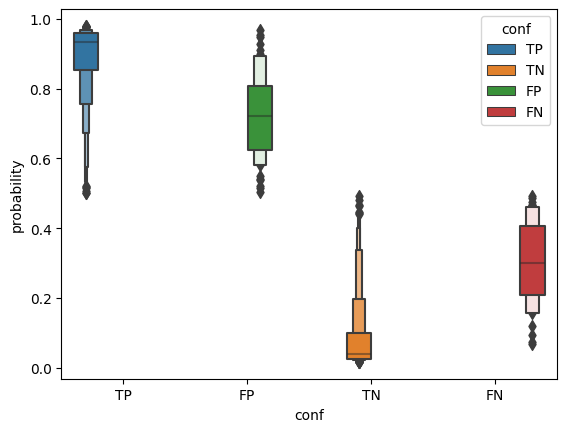

In [31]:
sns.boxenplot(x='conf', y='probability', data=y_bin_proba_conf, hue='conf', order=['TP','FP','TN','FN'])

pv, u, de, dl, sz = myMannWhitneyU_cliffsdelta(y_bin_proba_conf, 'probability', val1='TP', val2='FP')
print(f'Between TP and FP \np-value: {pv}, decision: {de}, \ncliff\'s delta: {dl}, effect size: {sz}')
pv, u, de, dl, sz = myMannWhitneyU_cliffsdelta(y_bin_proba_conf, 'probability', val1='TN', val2='FN')
print(f'Between TN and FN \np-value: {pv}, decision: {de}, \ncliff\'s delta: {dl}, effect size: {sz}')

### Distribution of confidence scores for TP, FP, TN and FN on test set

Between TP and FP 
p-value: 1.6480216883585996e-14, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.6677984084880637, effect size: large
Between TN and FN 
p-value: 2.236951701441565e-16, decision: With alpha=0.01, Reject null hypothesis - They have significant difference, 
cliff's delta: 0.8157248157248157, effect size: large


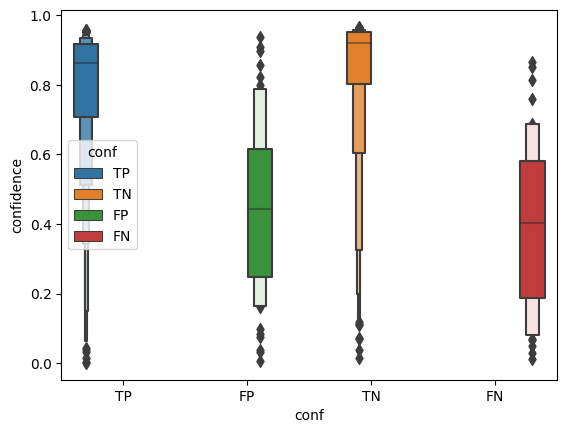

In [32]:
sns.boxenplot(x='conf', y='confidence', data=y_bin_proba_conf, hue='conf', order=['TP','FP','TN','FN'])

pv, u, de, dl, sz = myMannWhitneyU_cliffsdelta(y_bin_proba_conf, 'confidence', val1='TP', val2='FP')
print(f'Between TP and FP \np-value: {pv}, decision: {de}, \ncliff\'s delta: {dl}, effect size: {sz}')
pv, u, de, dl, sz = myMannWhitneyU_cliffsdelta(y_bin_proba_conf, 'confidence', val1='TN', val2='FN')
print(f'Between TN and FN \np-value: {pv}, decision: {de}, \ncliff\'s delta: {dl}, effect size: {sz}')

### Variation in performance for different values of confidence thresholds

In [33]:
confidence_thr_filter = 0.6
filt_confidence = (
    y_bin_proba_conf.query('confidence > @confidence_thr_filter')
    .conf.value_counts()
)
print('Original')
P_org = y_bin_proba_conf.query('conf == "TP"').shape[0]/(y_bin_proba_conf.query('conf == "TP"').shape[0]+ y_bin_proba_conf.query('conf == "FP"').shape[0])
R_org = y_bin_proba_conf.query('conf == "TP"').shape[0]/(y_bin_proba_conf.query('conf == "TP"').shape[0]+ y_bin_proba_conf.query('conf == "FN"').shape[0])
F1_org = 2*P_org*R_org/(P_org+R_org)
display(y_bin_proba_conf.conf.value_counts())
print(f'P: {P_org}, R: {R_org}, F1: {F1_org}')

print('\nAt least 60\% confidence')
P = filt_confidence["TP"]/(filt_confidence["TP"]+ filt_confidence["FP"])
R = filt_confidence["TP"]/(filt_confidence["TP"]+ filt_confidence["FN"])
F1 = 2*P*R/(P+R)
display(filt_confidence)
print(f'P: {P}, R: {R}, F1: {F1}')

Original


TN    396
TP    377
FP     50
FN     37
Name: conf, dtype: int64

P: 0.882903981264637, R: 0.9106280193236715, F1: 0.8965517241379312

At least 60\% confidence


TN    346
TP    315
FP     14
FN      8
Name: conf, dtype: int64

P: 0.9574468085106383, R: 0.9752321981424149, F1: 0.9662576687116565


<AxesSubplot: xlabel='confidence'>

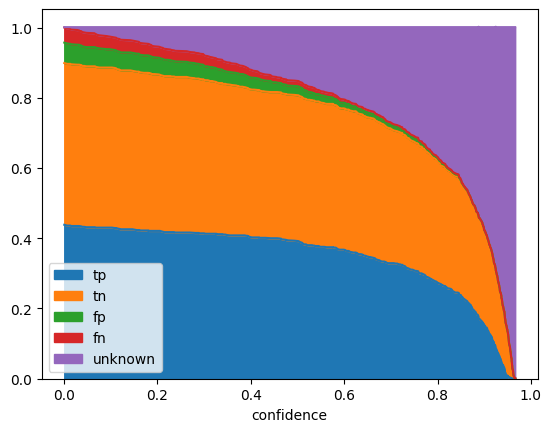

In [34]:
df_confidence_thresholds = (
    y_bin_proba_conf
    .set_index('confidence')
    .eval('''
    tp = bot == pred == 1;
    tn = bot == pred == 0;
    fp = bot == 0 and pred == 1;
    fn = bot == 1 and pred == 0;
    ''')
    [['tp', 'tn', 'fp', 'fn']]
    .sort_index(ascending=False)
    .cumsum()
    .sort_index()
    .assign(unknown=lambda d: d.assign(n=1).n.cumsum())
    .assign(p=lambda d: d.tp/(d.tp+d.fp), r=lambda d: d.tp/(d.tp+d.fn), f1=lambda d: (2*d.p*d.r/d.p+d.r))
)
(
    df_confidence_thresholds[['tp', 'tn', 'fp', 'fn','unknown']]
    .pipe(lambda df: df / len(df))
    .plot(kind='area', stacked=True)
)